In [100]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

import plotly.express as px
from plotnine import *
import textwrap

In [101]:
df= pd.read_csv('../data/raw/price_elasticity.csv')
df.head()

,CategoryName,ProductPrice,OrderQuantity,profit,event
0,Touring-1000 Yellow,36.038342,140,2426.772222,No Promo
1,Touring-1000 Yellow,29.263274,139,2045.150965,No Promo
2,Mountain-500 Silver,24.354412,176,1535.132544,No Promo
3,Road-150 Red,417.121893,36,8345.771271,No Promo
4,Road-150 Red,396.777456,44,8193.218608,No Promo


In [116]:
# fig = px.scatter(
#     df, x='ProductPrice', y='OrderQuantity', color='CategoryName',
#     opacity=0.6, trendline="lowess", template="none",
#     title='Product Sales: Price vs Quantity Analysis'
# )

# # Open in browser to avoid nbformat requirement
# fig.show(renderer="colab")

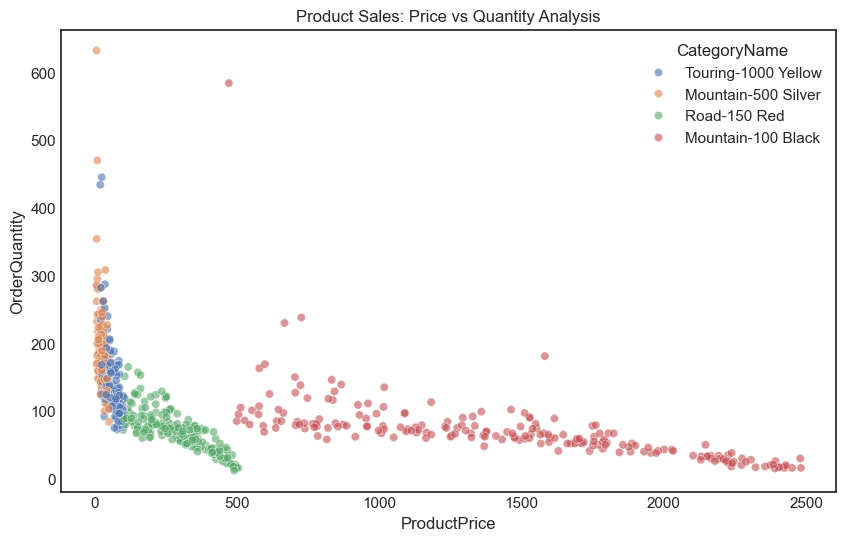

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(10, 6))

# Plot
sns.scatterplot(data=df, x='ProductPrice', y='OrderQuantity', hue='CategoryName', alpha=0.6)
#sns.regplot(data=df, x='ProductPrice', y='OrderQuantity', scatter=False, lowess=True, color='black')

plt.title('Product Sales: Price vs Quantity Analysis')
plt.show()

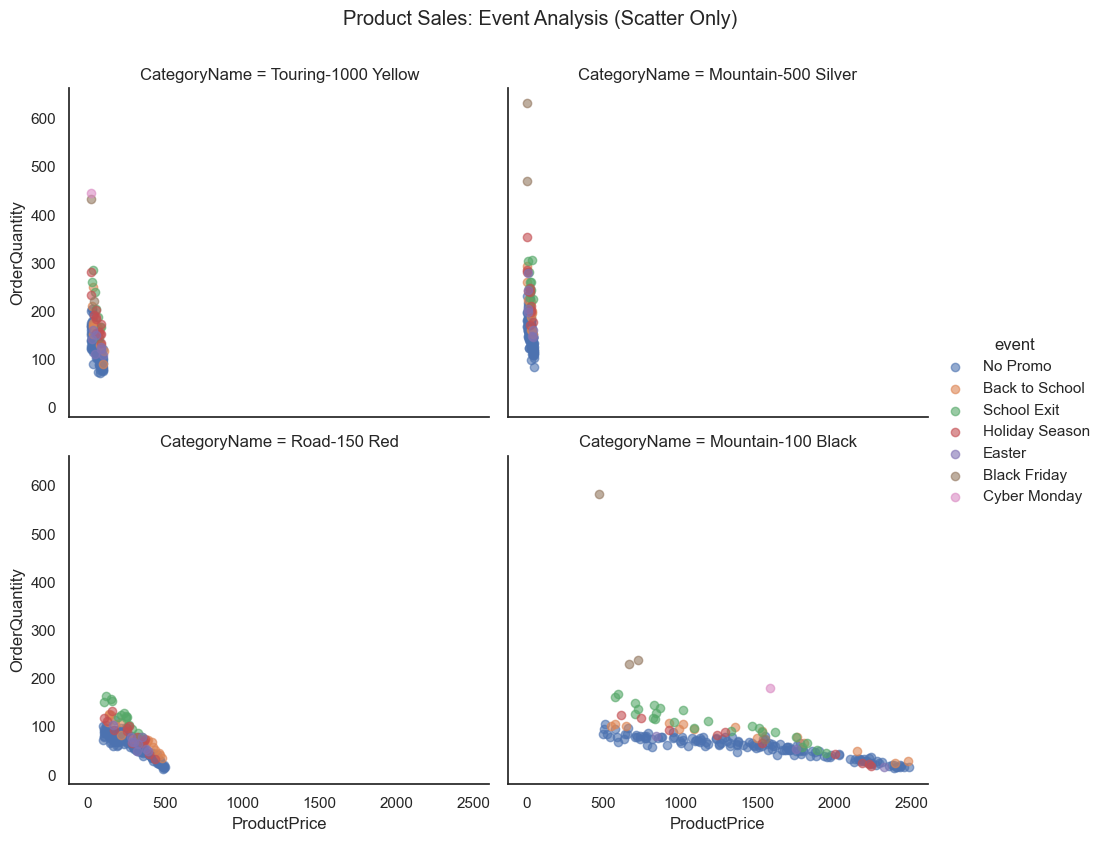

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Set 'fit_reg=False' to remove the regression/LOWESS line
g = sns.lmplot(
    data=df,
    x='ProductPrice', 
    y='OrderQuantity', 
    hue='event', 
    col='CategoryName', 
    col_wrap=2,
    fit_reg=False, 
    scatter_kws={'alpha':0.6},
    height=4, 
    aspect=1.2
)

g.fig.suptitle('Product Sales: Event Analysis (Scatter Only)', y=1.05)
plt.show()

### Model selection

In [105]:
import statsmodels.api as sm

# 1. Prepare Data
df_encoded = df.copy()

# 2. One-Hot Encoding for 'event' and 'CategoryName' (previously 'product')
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'CategoryName'], drop_first=True)

# 3. Clean up column names for modeling
# Categorical columns become binary (0 or 1)
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('event_')].tolist()
colnames_category = df_encoded.columns[df_encoded.columns.str.startswith('CategoryName_')].tolist()

for col in colnames_event + colnames_category:
    df_encoded[col] = df_encoded[col].astype(int)

# 4. Define Features (X) and Target (y)
# We use ProductPrice and the encoded event/category columns
X = df_encoded[['ProductPrice'] + colnames_event + colnames_category]
X = sm.add_constant(X) # Adds the intercept
y = df_encoded['OrderQuantity']

# 5. Fit OLS Model
model = sm.OLS(y, X).fit()

# 6. View Results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          OrderQuantity   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     277.1
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.57e-250
Time:                        21:01:47   Log-Likelihood:                -3874.2
No. Observations:                 800   AIC:                             7770.
Df Residuals:                     789   BIC:                             7822.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

**Price opt**

In [106]:
from pygam import ExpectileGAM, s

# 1. Filter and Prepare
data_filtered = df.query('event == "No Promo"')
unique_products = data_filtered['CategoryName'].unique()
all_gam_results = pd.DataFrame()

# 2. Fit GAM per Category
for product in unique_products:
    product_data = data_filtered[data_filtered['CategoryName'] == product]
    X_prod = product_data[['ProductPrice']]
    y_prod = product_data['OrderQuantity']
    
    # 3. Model Quantiles (0.025, 0.5, 0.975) for Uncertainty
    gam_results = {}
    for q in [0.025, 0.5, 0.975]:
        gam = ExpectileGAM(s(0), expectile=q).fit(X_prod, y_prod)
        gam_results[f"pred_{q}"] = gam.predict(X_prod)
        
    # 4. Combine Results
    predictions = pd.DataFrame(gam_results, index=X_prod.index)
    res = pd.concat([product_data[['ProductPrice', 'CategoryName', 'OrderQuantity']], predictions], axis=1)
    all_gam_results = pd.concat([all_gam_results, res], axis=0)

all_gam_results.head()

,ProductPrice,CategoryName,OrderQuantity,pred_0.025,pred_0.5,pred_0.975
0,36.038342,Touring-1000 Yellow,140,117.952766,143.421413,176.209714
1,29.263274,Touring-1000 Yellow,139,119.659863,152.322502,190.813917
7,61.222212,Touring-1000 Yellow,130,104.440599,125.880594,144.135680
17,65.235883,Touring-1000 Yellow,137,97.152846,120.977467,136.275417
18,84.761194,Touring-1000 Yellow,95,83.786128,101.925803,118.473986


In [107]:
# 7.0 PROFIT OPTIMIZATION
# -----------------------------------------------------------------------------
# Calculating predicted profit based on established margins
# Profit = (Actual Profit / Actual Quantity) * Predicted Quantity

# 1. Get the profit per unit (margin) from original data
df['UnitProfit'] = df['profit'] / df['OrderQuantity']
margin_map = df.groupby('CategoryName')['UnitProfit'].mean()

# 2. Apply margin to GAM predicted quantities
for col in all_gam_results.columns:
    if col.startswith('pred'):
        # Map margin to category
        all_gam_results['unit_margin'] = all_gam_results['CategoryName'].map(margin_map)
        
        # Calculate predicted profit
        all_gam_results['profit_' + col] = all_gam_results['unit_margin'] * all_gam_results[col]

# 3. Identify price points that maximize Median (0.5) Profit
best_profit_50 = all_gam_results.groupby('CategoryName').apply(
    lambda x: x[x['profit_pred_0.5'] == x['profit_pred_0.5'].max()].head(1)
).reset_index(level=0, drop=True)

best_profit_50[['CategoryName', 'ProductPrice', 'profit_pred_0.5']]

C:\Users\mmopa\AppData\Local\Temp\ipykernel_8868\2393099880.py:20: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,CategoryName,ProductPrice,profit_pred_0.5
143,Mountain-100 Black,498.237230,56876.936260
107,Mountain-500 Silver,5.127151,2310.584505
28,Road-150 Red,99.179845,11225.792676
101,Touring-1000 Yellow,23.268660,4040.539028


In [108]:
best_profit_50

,ProductPrice,CategoryName,OrderQuantity,pred_0.025,pred_0.5,pred_0.975,unit_margin,profit_pred_0.025,profit_pred_0.5,profit_pred_0.975
143,498.237230,Mountain-100 Black,85,78.060051,90.657963,103.295425,627.379379,48973.266274,56876.936260,64805.419435
107,5.127151,Mountain-500 Silver,169,170.565589,188.145538,230.827862,12.280836,2094.688034,2310.584505,2834.759130
28,99.179845,Road-150 Red,72,75.511852,89.712261,100.639792,125.131087,9448.880034,11225.792676,12593.166510
101,23.268660,Touring-1000 Yellow,129,127.434735,156.630364,194.610561,25.796652,3287.389531,4040.539028,5020.300958


### Visuals

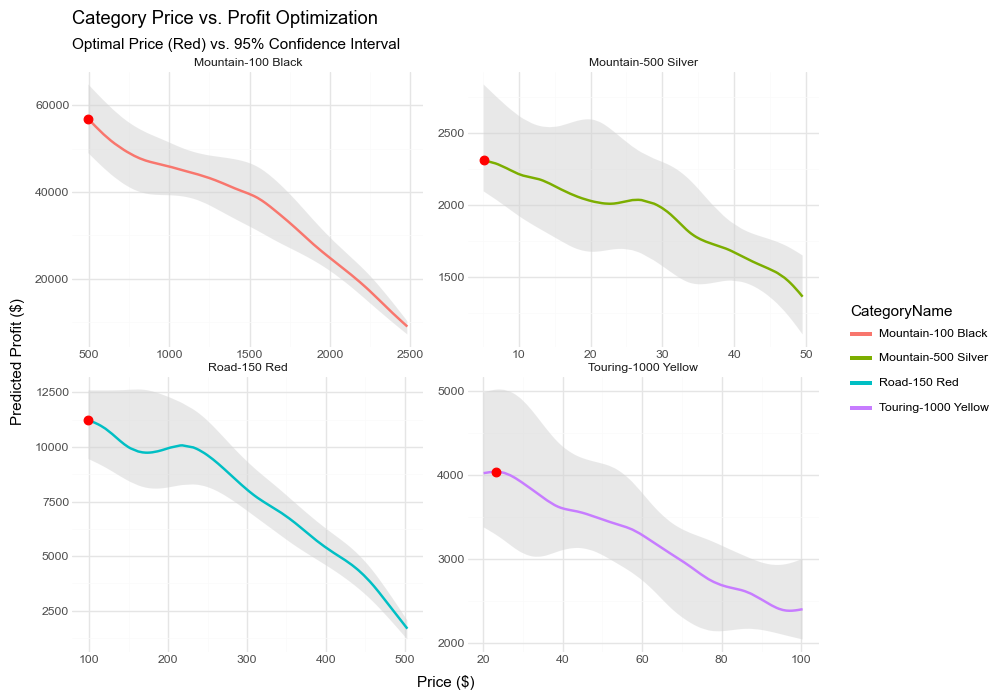

In [109]:
from plotnine import *
import matplotlib.pyplot as plt

plot = (
    ggplot(all_gam_results, aes(x='ProductPrice', y='profit_pred_0.5', color='CategoryName'))
    + geom_ribbon(aes(ymax='profit_pred_0.975', ymin='profit_pred_0.025'), 
                  fill="#d3d3d3", alpha=0.5, color=None, show_legend=False)
    + geom_line(size=1)
    + geom_point(data=best_profit_50, color="red", size=3)
    + facet_wrap('~CategoryName', scales='free')
    + labs(
        title="Category Price vs. Profit Optimization",
        subtitle="Optimal Price (Red) vs. 95% Confidence Interval",
        x="Price ($)",
        y="Predicted Profit ($)"
    )
    + theme_minimal()
    + theme(figure_size=(10, 7))
)

# Option 1: For Jupyter/IPython
plot.draw() 



In [111]:
# 8.0 MODELING GAMS WITH EVENTS
# -----------------------------------------------------------------------------
data_filtered = df.query('event != "No Promo"').copy()
events_only_gam_results = pd.DataFrame()

# Ensure no NaNs in the columns we are using
data_filtered = data_filtered.dropna(subset=['ProductPrice', 'OrderQuantity', 'event'])

for cat in data_filtered['CategoryName'].unique():
    cat_data = data_filtered[data_filtered['CategoryName'] == cat].copy()
    
    # Check 1: Minimum data points (GAMs usually need 10+ for splines/factors)
    if len(cat_data) < 5:
        print(f"Skipping {cat}: Not enough data ({len(cat_data)} rows)")
        continue 
        
    # Check 2: Variance (Price must change to calculate elasticity)
    if cat_data['ProductPrice'].nunique() <= 1:
        print(f"Skipping {cat}: No price variation")
        continue

    # Prepare X and y
    le = LabelEncoder()
    # We must convert X to a float array for pyGAM
    X = pd.DataFrame({
        'price': cat_data['ProductPrice'],
        'event': le.fit_transform(cat_data['event'])
    }).values 
    y = cat_data['OrderQuantity'].values
    
    try:
        # l(0) = linear (price), f(1) = factor (event)
        gam = GAM(l(0) + f(1)).fit(X, y)
        cat_data['pred_0.5'] = gam.predict(X)
        events_only_gam_results = pd.concat([events_only_gam_results, cat_data], axis=0)
    except Exception as e:
        print(f"Error modeling {cat}: {e}")

print(f"Final results count: {len(events_only_gam_results)}")

Final results count: 204


In [112]:
events_only_gam_results

,CategoryName,ProductPrice,OrderQuantity,profit,event,UnitProfit,pred_0.5
5,Road-150 Red,129.815081,111,5324.566299,Back to School,47.969066,126.646142
12,Road-150 Red,267.879868,102,13563.260247,Holiday Season,132.973140,86.845083
21,Road-150 Red,333.221491,78,9409.502423,School Exit,120.634646,90.510162
37,Road-150 Red,247.641338,122,9658.746823,School Exit,79.170056,112.451467
44,Road-150 Red,327.611442,87,10342.630738,School Exit,118.880813,91.948484
...,...,...,...,...,...,...,...
737,Mountain-100 Black,865.243513,139,55794.569463,School Exit,401.399780,132.336882
750,Mountain-100 Black,2178.967150,26,25213.334711,Holiday Season,969.743643,23.335030
765,Mountain-100 Black,989.297843,96,51966.398404,Back to School,541.316650,111.788305
768,Mountain-100 Black,1944.655706,46,41543.940758,School Exit,903.129147,56.040682


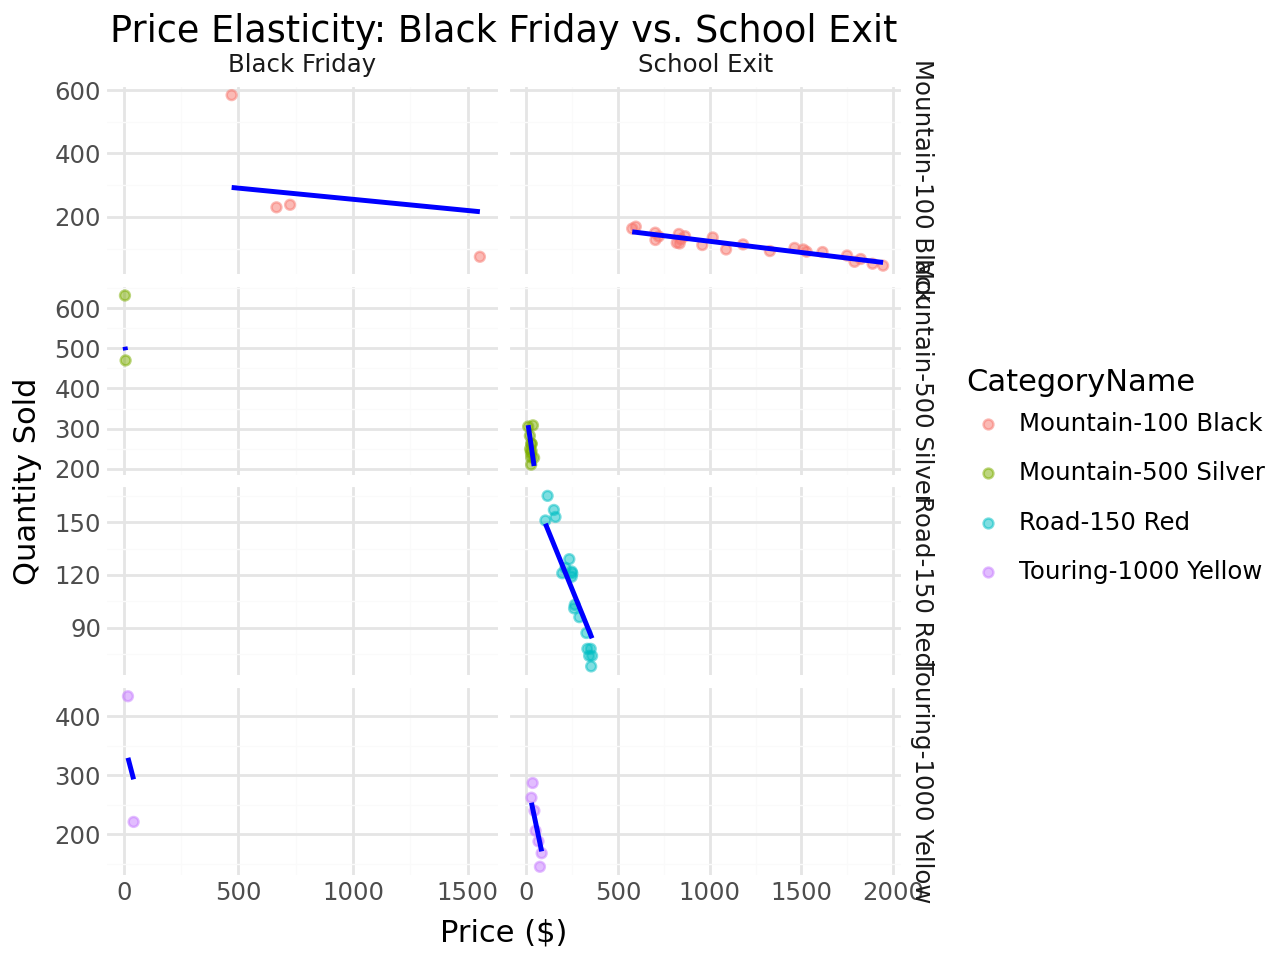

In [113]:
from plotnine import *

# 9.0 VISUALIZE EVENT-BASED PRICE MODELS
# -----------------------------------------------------------------------------
# Filter for specific comparison: Black Friday vs School Exit
plot_df = events_only_gam_results[
    events_only_gam_results['event'].isin(['Black Friday', 'School Exit'])
]

(
    ggplot(plot_df, aes(x='ProductPrice', y='OrderQuantity', color='CategoryName'))
    + geom_point(alpha=0.5) 
    + geom_line(aes(y="pred_0.5"), color="blue", size=1) 
    + facet_grid('CategoryName ~ event', scales="free") 
    + labs(
        title="Price Elasticity: Black Friday vs. School Exit",
        x="Price ($)",
        y="Quantity Sold"
    )
    + theme_minimal() # Replaced tk.theme for compatibility; swap back if available
)

In [119]:
# 10.0 OPTIMIZE PRICE FOR EVENT PROFIT
# -----------------------------------------------------------------------------
# 1. Calculate Unit Cost (based on your existing profit/price/qty relationship)
# UnitCost = Price - (Total Profit / Quantity)
events_only_gam_results['UnitCost'] = (
    events_only_gam_results['ProductPrice'] - 
    (events_only_gam_results['profit'] / events_only_gam_results['OrderQuantity'])
)

# 2. Calculate predicted profit for event periods
for col in events_only_gam_results.columns:
    if col.startswith('pred'):
        # Profit = (Price - UnitCost) * Predicted Quantity
        events_only_gam_results['profit_' + col] = (
            (events_only_gam_results['ProductPrice'] - events_only_gam_results['UnitCost']) * events_only_gam_results[col]
        )

events_only_gam_results.head(3)

,CategoryName,ProductPrice,OrderQuantity,profit,event,UnitProfit,pred_0.5,UnitCost,profit_pred_0.5
5,Road-150 Red,129.815081,111,5324.566299,Back to School,47.969066,126.646142,81.846015,6075.097114
12,Road-150 Red,267.879868,102,13563.260247,Holiday Season,132.973140,86.845083,134.906729,11548.063350
21,Road-150 Red,333.221491,78,9409.502423,School Exit,120.634646,90.510162,212.586845,10918.661346


In [131]:
# 11.0 UNIFIED PERFORMANCE TABLE: BASELINE VS. EVENT OPTIMIZATION
# -----------------------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, l, f
import pandas as pd

# 1. CREATE BASELINE REFERENCE (Locked to 'No Promo' Median)
baseline = df[df['event'] == 'No Promo'].groupby('CategoryName').agg({
    'ProductPrice': 'median',
    'OrderQuantity': 'median',
    'profit': 'median'
}).reset_index()
baseline.columns = ['Item Name', 'Orig Price', 'Orig Qty', 'Orig Profit']

unique_items = df['CategoryName'].unique()
all_results = []

# 2. MODELING & PREDICTION LOOP
for item in unique_items:
    item_data = df[df['CategoryName'] == item].copy()
    
    le = LabelEncoder()
    X_input = pd.DataFrame({
        'price': item_data['ProductPrice'],
        'event_enc': le.fit_transform(item_data['event'])
    })
    
    # Fit GAM: index 0 (Price), index 1 (Event)
    gam = GAM(l(0) + f(1)).fit(X_input, item_data['OrderQuantity'])
    
    # Predict for each event's median price
    event_summary = item_data.groupby('event').agg({'ProductPrice': 'median'}).reset_index()
    X_pred = pd.DataFrame({
        'price': event_summary['ProductPrice'],
        'event_enc': le.transform(event_summary['event'])
    })
    
    # Calculate Expected metrics
    event_summary['Exp Qty'] = gam.predict(X_pred)
    event_summary['Exp Revenue'] = event_summary['ProductPrice'] * event_summary['Exp Qty']
    
    # Calculate Exp Profit using median Unit Cost
    unit_cost = (item_data['ProductPrice'] - (item_data['profit'] / item_data['OrderQuantity'])).median()
    event_summary['Exp Profit'] = (event_summary['ProductPrice'] - unit_cost) * event_summary['Exp Qty']
    event_summary['Item Name'] = item
    
    all_results.append(event_summary)

# 3. MERGE & ORGANIZE
final_table = pd.merge(pd.concat(all_results), baseline, on='Item Name', how='left')
final_table = final_table.rename(columns={'ProductPrice': 'Adjusted Price', 'event': 'Event'})

# Final Column Order
final_table = final_table[[
    'Item Name', 
    'Orig Price', 'Orig Qty', 'Orig Profit',
    'Adjusted Price', 'Exp Qty', 'Exp Revenue', 'Exp Profit', 
    'Event'
]]

# 4. SORT: No Promo First
final_table['is_promo'] = final_table['Event'] != 'No Promo'
final_table = final_table.sort_values(['Item Name', 'is_promo', 'Event']).drop(columns=['is_promo'])

In [134]:
final_table.head(10).round(2)

,Item Name,Orig Price,Orig Qty,Orig Profit,Adjusted Price,Exp Qty,Exp Revenue,Exp Profit,Event
23,Mountain-100 Black,1519.95,61.0,32365.42,1519.95,56.48,85849.35,40436.52,No Promo
18,Mountain-100 Black,1519.95,61.0,32365.42,1357.68,84.74,115044.71,46914.33,Back to School
19,Mountain-100 Black,1519.95,61.0,32365.42,695.38,269.65,187512.83,-29296.79,Black Friday
20,Mountain-100 Black,1519.95,61.0,32365.42,1581.31,152.40,240987.88,118455.89,Cyber Monday
21,Mountain-100 Black,1519.95,61.0,32365.42,1753.44,54.77,96043.83,52003.57,Easter
22,Mountain-100 Black,1519.95,61.0,32365.42,1412.41,74.90,105789.94,45567.82,Holiday Season
24,Mountain-100 Black,1519.95,61.0,32365.42,1052.67,115.32,121398.74,28674.29,School Exit
11,Mountain-500 Silver,31.54,148.0,1869.43,31.54,149.12,4702.63,2320.01,No Promo
7,Mountain-500 Silver,31.54,148.0,1869.43,29.47,206.78,6093.79,2789.92,Back to School
8,Mountain-500 Silver,31.54,148.0,1869.43,6.66,490.79,3266.28,-4575.53,Black Friday
